<a href="https://colab.research.google.com/github/aglucaci/AlignmentProfiles/blob/main/AlignmentProfiler_Public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:**

A useful notebook to assess a coding sequence alignment

@Author: Alexander Lucaci

**Current Features**

*   Get nucleotide frequencies
*   Get site likelihood statistics
*   Get GC Content
*   Get Amino acid relative frequencies
*   Get essential versus non-essential amino acid statistics
*   Get ungapped nucleotide content
*   Bootstrap an alignment
*   Test for ambiguous characters
*   Get gap character analysis
*   Get codon diversity
*   Get protein diversity
*   Generate Hamming distance plot
*   Get Jukes-Cantor distances
*   Get Relative Synonymous Codon Usage (RSCU)





# **Step 1: Gather Data**

In [ ]:
# Download test dataset
# In this case, we are using an recombination free alignment of the BDNF gene across a number of species.
#!wget -O BDNF_codons_RDP_recombinationFree.fas https://raw.githubusercontent.com/aglucaci/AnalysisOfOrthologousCollections/main/results/BDNF/Recombinants/BDNF_codons_RDP_recombinationFree.fas

--2022-02-25 19:52:30--  https://raw.githubusercontent.com/aglucaci/AnalysisOfOrthologousCollections/main/results/BDNF/Recombinants/BDNF_codons_RDP_recombinationFree.fas
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108612 (106K) [text/plain]
Saving to: ‘BDNF_codons_RDP_recombinationFree.fas’

BDNF_codons_RDP_rec 100%[===================>] 106.07K  --.-KB/s    in 0.01s   

2022-02-25 19:52:30 (7.02 MB/s) - ‘BDNF_codons_RDP_recombinationFree.fas’ saved [108612/108612]



# **Step 2: Install dependencies**

In [ ]:
# Installers
#!pip install biopython

     |████████████████████████████████| 2.3 MB 7.7 MB/s 


In [3]:
# Imports
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import random
from matplotlib import pyplot as plt
import itertools
import numpy as np
from matplotlib.pyplot import figure
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
#import numpy as np 
from pandas import DataFrame
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

# **Step 3: Set declared variables**

In [4]:
# Declares
input_file = os.path.join("..", "results", "mammalian_REM2", "mammalian_REM2_codons.SA.fasta")

In [5]:
# This analysis only uses the standard genetic code, it will need to be updated in the future to accomdate others

CodonTable = {'A': {'GCA': 0, 'GCC': 0, 'GCG': 0, 'GCT': 0},
                'C': {'TGC': 0, 'TGT': 0},
                'D': {'GAC': 0, 'GAT': 0},
                'E': {'GAA': 0, 'GAG': 0},
                'F': {'TTC': 0, 'TTT': 0},
                'G': {'GGA': 0, 'GGC': 0, 'GGG': 0, 'GGT': 0},
                'H': {'CAC': 0, 'CAT': 0},
                'I': {'ATA': 0, 'ATC': 0, 'ATT': 0},
                'K': {'AAA': 0, 'AAG': 0},
                'L': {'CTA': 0, 'CTC': 0, 'CTG': 0, 'CTT': 0, 'TTA': 0, 'TTG': 0},
                'M': {'ATG': 0},
                'N': {'AAC': 0, 'AAT': 0},
                'P': {'CCA': 0, 'CCC': 0, 'CCG': 0, 'CCT': 0},
                'Q': {'CAA': 0, 'CAG': 0},
                'R': {'AGA': 0, 'AGG': 0, 'CGA': 0, 'CGC': 0, 'CGG': 0, 'CGT': 0},
                'S': {'AGC': 0, 'AGT': 0, 'TCA': 0, 'TCC': 0, 'TCG': 0, 'TCT': 0},
                'T': {'ACA': 0, 'ACC': 0, 'ACG': 0, 'ACT': 0},
                'V': {'GTA': 0, 'GTC': 0, 'GTG': 0, 'GTT': 0},
                'W': {'TGG': 0},
                'X': {'CAN': 0,
                      'NAT': 0,
                      'NCA': 0,
                      'NCT': 0,
                      'NGG': 0,
                      'NNC': 0,
                      'NTC': 0,
                      'NTT': 0,
                      'GNT': 0
                      },
                'Y': {'TAC': 0, 'TAT': 0}}

# **Define AlignmentProfiler Class**

In [7]:
# Classes

class AlignmentProfiler(): # Loads in a fasta dictionary
  def __init__(self, FASTA_FILE, CodonTable):
    self.FASTA_DICT = self.process_sites(FASTA_FILE)
    self.CodonTable = CodonTable
    self.num_sites = self.get_num_sites()
    self.num_sequences = self.get_num_sequences()
    self.alignment_type = "DNA" # Default
    self.gap_character = "-" # Default
    self.DNA_Characters = ["T", "C", "G", "A"]
  #end method

  def get_num_sites(self):
    num_sites = 1
    #assert, error check here
    for item in self.FASTA_DICT.keys():
      num_sites = len(self.FASTA_DICT[item].keys())                   # assumes symmetric matrix
      break
    #end for
    return num_sites
  #end method

  def get_num_sequences(self):
    return len(self.FASTA_DICT.keys())
  #end method

  def process_sites(self, input_file):                                # generally initalizes the class.
    fasta_sequence = SeqIO.parse(open(input_file),'fasta')
    fasta_dict = {}                                                   #init
    for record in fasta_sequence:                                     #loops over each species
      ID, SEQ, site_count, nt_num = record.id, record.seq, 1, 0
      fasta_dict[ID] = {}                                             #init
      while SEQ[nt_num:nt_num+3]:                                     # loop over codons
        codon = str(SEQ[nt_num:nt_num+3])
        fasta_dict[ID]["Site" + str(site_count)] = codon
        site_count += 1
        nt_num += 3
      #end while
    #end for
    return fasta_dict
  #end method

  def gaps_distribution(self):
    gap_freq, site_count = [], 1
    while site_count <= self.num_sites:
      column_codons = []
      for num_species, species in enumerate(self.FASTA_DICT.keys()):  # Loop over each species in the alignment.
        Site = "Site" + str(site_count)                               # For this site (site_count) get the codon, and add it to the list.
        if self.FASTA_DICT[species].get(Site) != None:                # make sure key exists
          codon = self.FASTA_DICT[species][Site]
          column_codons.append(codon)                                 # Generate list of Codons at that site.
        else:
          break                                                       # A key error has been reached, no more sites.
        #end if
      #end for
      num_gaps = 0
      num_gaps = column_codons.count("---")                           # Analyze this Site (column in an alignment)
      if num_gaps != 0:
        gap_freq.append(num_gaps/len(column_codons))
      else:
        gap_freq.append(0)
      site_count += 1
    #end while
    return gap_freq
  #end method

  def ambiguous_characters(self):
    output = {}
    for num_species, species in enumerate(self.FASTA_DICT.keys()): #Loop over the sequences,
      #print("Searching over:", species) # Loop over the sites in each sequence
      site_count = 1
      while site_count <= self.num_sites:
        Site = "Site" + str(site_count) 
        codon = self.FASTA_DICT[species][Site]
        #print(Site, codon)
        for nt in codon: # are any characters beside DNA or gap char?
          if nt.upper() not in self.DNA_Characters and nt.upper() != self.gap_character: #char is not a DNA or gap
            try:
              output[species] += [site_count, codon]
            except:
              output[species] = [site_count, codon]
            #end try
          #end if
        #end inner for
        site_count += 1
      #end while
    #end outer for
    return output # Output should be just the taxa name for now.
  #end method

  def codon_diversity(self):
    assert(self.FASTA_DICT != None, "Error")                          # simple checks
    output, site_count = [], 1
    while site_count <= self.num_sites:
      column_codons = []
      for num_species, species in enumerate(self.FASTA_DICT.keys()):  # Loop over each species in the alignment.
        Site = "Site" + str(site_count)                               # For this site (site_count) get the codon, and add it to the list.
        if self.FASTA_DICT[species].get(Site) != None:                # make sure key exists
          codon = self.FASTA_DICT[species][Site]
          column_codons.append(codon)                                 # Generate list of Codons at that site.
        else:
          break                                                       # A key error has been reached, no more sites.
        #end if
      #end for
      codon_set = set(column_codons)                                  # check for variance.
      num_unique = len(codon_set)
      if "---" in codon_set: num_unique -= 1                          # In this case, we do NOT count a gap site ("---") as a codon.
      output.append(num_unique)
      site_count += 1
    #end while
    return output # returns a list of codon diversity (number of codons) at each site
  #end method

  def protein_diversity(self):
    assert(self.FASTA_DICT != None, "Error")                          # simple checks
    output, site_count = [], 1
    while site_count <= self.num_sites:
      column_codons = []
      for num_species, species in enumerate(self.FASTA_DICT.keys()):  # Loop over each species in the alignment.
        Site = "Site" + str(site_count)                               # For this site (site_count) get the codon, and add it to the list.
        if self.FASTA_DICT[species].get(Site) != None:                # make sure key exists
          codon = self.FASTA_DICT[species][Site]
          AA = Seq(codon).translate()
          #print(codon, AA)
          #column_codons.append(codon)                                 # Generate list of Codons at that site.
          column_codons.append(AA)
        else:
          break                                                       # A key error has been reached, no more sites.
        #end if

      #end for
      codon_set = set(column_codons)                                  # check for variance.
      num_unique = len(codon_set)
      if "---" in codon_set:
         num_unique -= 1                          # In this case, we do NOT count a gap site ("---") as a codon.
      #end if
      output.append(num_unique)
      site_count += 1
    #end while
    return output # returns a list of codon diversity (number of codons) at each site
  #end method

  def invariant_sites(self):
    assert(self.FASTA_DICT != None, "Error") # simple checks
    output, site_count = [], 1
    while site_count <= self.num_sites:
      column_codons = []
      for num_species, species in enumerate(self.FASTA_DICT.keys()):  # Loop over each species in the alignment.
        Site = "Site" + str(site_count)         # For this site (site_count) get the codon, and add it to the list.
        if self.FASTA_DICT[species].get(Site) != None: # make sure key exists
          codon = self.FASTA_DICT[species][Site]
          column_codons.append(codon) # Generate list of Codons at that site.
        else:
          break # A key error has been reached, no more sites.
        #end if
      #end for
      codon_set = set(column_codons) # check for variance.
      num_unique = len(codon_set)
      if "---" in codon_set: num_unique -= 1  # In this case, we do NOT count a gap site ("---") as a codon.
      if num_unique == 1:  # Is there more than 1 codon at this site? If so, it is variant. 
        output.append(site_count)
      #end if
      site_count += 1
    #end while
    return output # returns a list of invariant sites.
  #end method

  def get_site_sequence(self, Site): # get an entire columns info.
    column_codons = []
    #print("# Processing:", Site)
    Site = "Site" + str(Site)
    for num_species, species in enumerate(self.FASTA_DICT.keys()):  # Loop over each species in the alignment.
      if self.FASTA_DICT[species].get(Site) != None:
        codon = self.FASTA_DICT[species][Site]
        column_codons.append(codon) # Generate list of Codons at that site.
      else: 
        print("# Error,", species, Site)
      #end if
    #end for
    return column_codons # returns a list, with the codons at a particular site in an alignment. This loses taxa info though.
  #end method

  def get_full_sequence(self, TAXA_Name): #full sequence for a species
      output = []
      site_count = 1
      while site_count <= self.num_sites:
        Site = "Site" + str(site_count) 
        codon = self.FASTA_DICT[TAXA_Name][Site]
        output.append(codon)
        site_count += 1
      #end while
      return output # actually outputs a list of codons
  #end method

  def calculate_hamming_distance(self, chain1, chain2):
    return sum(c1 != c2 for c1, c2 in zip(chain1, chain2))

  def pairwise_distances(self): # p-distance, hamming distance
    pairwise_dict = {}
    species = list(TEST.FASTA_DICT.keys())
    # list(itertools.combinations(species, 2))
    for n, pair in enumerate(list(itertools.combinations(species, 2))):
      #print(n, pair)
      A = pair[0]
      B = pair[1]
      A_seq = "".join(self.get_full_sequence(A))
      B_seq = "".join(self.get_full_sequence(B))
      HD = self.calculate_hamming_distance(A_seq, B_seq)
      try:
        pairwise_dict[A][B] = HD
      except:
        pairwise_dict[A] = {B: HD}
      #end try
      #pairwise_dict[A][B] = HD
    #end for
    return pairwise_dict
  #end method

  def RSCU_forEachSpecies(self):
    # Each species would have its own RSCU
    #for single_amino_acid in Amino_Acids:
    #dict[AA] = {"Codon1": observed_number_for_codon1, "Codon2": observed_number_for_codon}
    #X_average = (sum(dict[AA]) / num_of_codons_for[AA])
    # Each species would have its own RSCU
    RSCU_counts = {}
    for num_species, species in enumerate(self.FASTA_DICT.keys()):  # Loop over each species in the alignment.
      #RSCU_counts[species] = {}
      # Get the codons for this species
      codon_list = self.get_full_sequence(species)
      for codon in codon_list:
        if codon == "---": continue
        AminoAcid = str(Seq(codon).translate())
        try:
          RSCU_counts[species][AminoAcid][codon] += 1
        except:
          RSCU_counts[species][AminoAcid] = {codon : 1}
        #end try
      #end for
    #end for

    # Convert counts into RSCU frequency
    RSCU_dict = {}
    # For each Amino acid which the species (sequence) uses.
    # m = number of codons for an amino acid
    # X_i = observed numer of ith codon for the amino acid
    # X_bar =  
    return RSCU_counts
  #end method

  def RSCU(self):
    RSCU_counts = self.CodonTable
    for num_species, species in enumerate(self.FASTA_DICT.keys()):  # Loop over each species in the alignment.
      # Get the codons for this species
      #print(species)
      codon_list = self.get_full_sequence(species)
      #print(codon_list)
      for codon in codon_list:
        if codon == "---": continue                                 # skip gaps
        if "-" in codon: # invalid codon, add as X
          try:
            RSCU_counts["X"][codon] += 1
          except:
            RSCU_counts["X"][codon] = 1
          #end try
          continue
        #end if
        AminoAcid = str(Seq(codon).translate())
        #RSCU_counts[AminoAcid][codon] += 1
        try:
            RSCU_counts[AminoAcid][codon] += 1
        except:
            RSCU_counts[AminoAcid][codon] = 1
        #end try
      #end for
    #end for
    # Convert counts into RSCU frequency
    RSCU_dict = self.CodonTable
    # For each Amino acid which the species (sequence) uses.
    # m = number of codons for an amino acid
    # X_i = observed numer of ith codon for the amino acid
    # X_bar =  sum(X_i)/m
    for AA in RSCU_counts.keys():
      m = len(RSCU_counts[AA]) # number of codons
      # Calculate sum
      X_bar = 1
      for codon in RSCU_counts[AA]:
        X_bar += RSCU_counts[AA][codon]
      #end for
      X_bar = X_bar / m # normalized
      for codon in RSCU_counts[AA]:
        X_i = RSCU_counts[AA][codon]
        RSCU_dict[AA][codon] = X_i / X_bar
      #end for
    return RSCU_dict

  def bootstrap_columns(self):
    N = 1 #Number of alignments to bootstrap, this can be expand to return multiple lists, but the user can control this downstream
    low = 1 # start codon
    high = int(self.num_sites) # end of alignment, also length of alignment
    #x = random.uniform(low, high, high)
    rng = np.random.default_rng()
    s = rng.integers(low, high, size=high)
    return s

  #end method

  def JukesCantorDistance(self):
    pairwise_dict = {}
    species = list(TEST.FASTA_DICT.keys())
    for n, pair in enumerate(list(itertools.combinations(species, 2))):
      A, B = pair[0], pair[1]
      A_seq, B_seq = "".join(self.get_full_sequence(A)), "".join(self.get_full_sequence(B))
      p = self.calculate_hamming_distance(A_seq, B_seq) / len(A_seq)
      JC = -(3/4)*np.log(1-(4/3)*p)

      # Jukes-Cantor Variance
      # https://www.megasoftware.net/web_help_7/hc_jukes_cantor_distance.htm
      #JCD = p (1 - p) / ( ( (1 - (4 / 3) * p)**2 ) * L)
      try:
        pairwise_dict[A][B] = JC
        #pairwise_dict[A][B]["JCD"] = JC
      except:
        pairwise_dict[A] = {B: JC}
      #end try
    #end for
    return pairwise_dict
  #end method

  def pairwise_KaKs(self):
    pairwise_dict, species = {}, list(TEST.FASTA_DICT.keys())
    results = {}
    #for n, pair in enumerate(list(itertools.combinations(species, 2))):
    #for n, pair in tqdm(enumerate(list(itertools.combinations(species, 2)))):
    for pair in tqdm(list(itertools.combinations(species, 2))):
      A, B = pair[0], pair[1]
      #print("# Comparing:", A, B)
      A_Seq, B_Seq = self.get_full_sequence(A), self.get_full_sequence(B)
      site, Ka, Ks = 0, 0, 0
      while site < len(A_Seq):
        try:
            codon1, aminoAcid1 = A_Seq[site], Seq(A_Seq[site]).translate()
            codon2, aminoAcid2 = B_Seq[site], Seq(B_Seq[site]).translate()
        except:
          site += 1
          continue
        #end try
        #print ("# Comparing", site+1, codon1, codon2, aminoAcid1, aminoAcid2, Ka, Ks)
        if aminoAcid1 == "-" or aminoAcid2 == "-": 
          #print("# Skipping gap")
          site += 1
          continue
        #end if 
        if aminoAcid1 == aminoAcid2: 
          Ka += 1
        else:
          Ks += 1
        #end if
        site += 1
      #end while
 
      #print(Ka, Ks, Ka/Ks)
      if Ks > 0: 
        value = Ka/Ks
      else:
        #value = "undefined"
        value = 0.00000001 # REVIEW THIS
      #end if

      #results[A] = {B: value}
      if A in results.keys():
        #results[A].append({B: value})
        results[A][B] = value
      else:
        results[A] = {B: value}

    #end for
    return results
  #end method

#end class

<>:93: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:116: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:145: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:93: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:116: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:145: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-7-2cba0254e8e4>:93: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.FASTA_DICT != None, "Error")                          # simple checks
<ipython-input-7-2cba0254e8e4>:116: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.FASTA_DICT != None, "Error")                          # simple checks
<ipython-input-7-2cba0254e8e4>:145: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.FASTA_DICT != None, "Error") # simple checks

# **Helper functions**

In [8]:
# Helper function ------
def search(values, searchFor):
    for k in values:
        for v in values[k]:
            if searchFor in v:
                return k
            #end if
        #end for
    #end for
    return None
#end method

d = {'CYSTEINE': 'C', 'ASPARTIC ACID': 'D', 'SERINE': 'S', 'GLUTAMINE': 'Q', 'LYSINE': 'K',
     'ISOLEUCINE': 'I', 'PROLINE': 'P', 'THREONINE': 'T', 'PHENYLALANINE': 'F', 'ASPARAGINE': 'N', 
     'GLYCINE': 'G', 'HISTIDINE': 'H', 'LEUCINE': 'L', 'ARGININE': 'R', 'TRYPTOPHAN': 'W', 
     'ALANINE': 'A', 'VALINE':'V', 'GLUTAMIC ACID': 'E', 'TYROSINE': 'Y', 'METHIONINE': 'M'}


# **Main**

In [9]:
# Main instance here
print("# Starting to profile:", input_file)
TEST = AlignmentProfiler(input_file, CodonTable)
print("# Loading complete")

# Starting to profile: ..\results\mammalian_REM2\mammalian_REM2_codons.SA.fasta
# Loading complete


In [10]:
# Summary stats
print("# Loaded an alignment from:", input_file)
print("# This alignment contains", TEST.num_sequences, "sequences")
print("# This alignment contains", TEST.num_sites, "sites")
print("# Number of invariant sites in alignment:", len(TEST.invariant_sites()))
print("# Fraction of invariant sites in alignment:", len(TEST.invariant_sites())/TEST.num_sites)
gap_list = TEST.gaps_distribution()
avg_gap = sum(gap_list)/ len(gap_list)
print("# Average measure of gappiness in alignment is:", avg_gap)
print("# Maximum measure of gappiness in alignment at a particular site is:", max(gap_list))
print("# Minimum measure of gappiness in alignment at a particular site is:", min(gap_list))

#TODO:
# N Fraction: Average, min, max
# GC Content
# NT frequencies
# Codon frequencies
# 2.17.2021: Analytical distance measures for different substitution
# Transitition, transversion ratio (a, b) (P, Q)
# but this notebook here: https://colab.research.google.com/drive/1Ja0mgJsfw0JanPCvqxiHymsufmLnVBWN#scrollTo=YXGdcMj3jRbV
# Goal is to fit a GTR model
# MLE https://colab.research.google.com/drive/1prrbuFn8cZS1l0SOJV31m01qEVj-Az1M#scrollTo=lLzESNGOM7v_
# NN https://colab.research.google.com/drive/1HcPbtJbtNtVPzaCTtHWNOKRvkcT9-3IE#scrollTo=OEdjYgkQ0IzF
# SeqLogo https://colab.research.google.com/drive/11GuHdvfe0J7E9kVxlRE_z-ZqXDyVBFoW#scrollTo=z5VSde3yot4h
#         https://colab.research.google.com/drive/1H-2RYu5BkClHXJMlDVA_evrv4-gGA8N_
# Page 46 in Sudhirs book.
# Port https://observablehq.com/@stevenweaver/fitch-algorithm
# Essential or non-essential amino acids


# Loaded an alignment from: ..\results\mammalian_REM2\mammalian_REM2_codons.SA.fasta
# This alignment contains 175 sequences
# This alignment contains 656 sites
# Number of invariant sites in alignment: 232
# Fraction of invariant sites in alignment: 0.35365853658536583
# Average measure of gappiness in alignment is: 0.48122822299651363
# Maximum measure of gappiness in alignment at a particular site is: 0.9942857142857143
# Minimum measure of gappiness in alignment at a particular site is: 0


# **NT Frequencies**

In [11]:
count_A = 0
count_T = 0
count_C = 0
count_G = 0
count_N = 0

total_num_nt = 0
# Loop over sequences

for key in TEST.FASTA_DICT.keys():
  seq = "".join(TEST.get_full_sequence(key))
  seq = seq.replace("-", "")
  for nt in seq:
    if nt.upper() == "A": count_A += 1
    if nt.upper() == "T": count_T += 1
    if nt.upper() == "C": count_C += 1
    if nt.upper() == "G": count_G += 1
    if nt.upper() == "N": count_N += 1
    total_num_nt += 1
  #end for
#end for

pi_A = count_A / total_num_nt
pi_T = count_T / total_num_nt
pi_C = count_C / total_num_nt
pi_G = count_G / total_num_nt
pi_N = count_N / total_num_nt

print("\n-- empirical nucleotides frequencies --")
#print(count_A, count_T , count_C , count_G )
#print("A:", pi_A, "T:", pi_T, pi_C, pi_G)
print("A:", pi_A)
print("T:", pi_T)
print("C:", pi_C)
print("G:", pi_G)

print()
print("GC:", pi_C + pi_G)
print("N:", pi_N)
# DEBUG -- sanity check --Doesn't sum to 1? Ambiguous characters might be present.
#print(sum([pi_A, pi_T, pi_C, pi_G]))
#print(pi_N)
#print(sum([pi_A, pi_T, pi_C, pi_G, pi_N]))


-- empirical nucleotides frequencies --
A: 0.21374639688803068
T: 0.16067500629670053
C: 0.321103741639381
G: 0.30447485517588785

GC: 0.6255785968152688
N: 0.0


# **Site likelihood**




In [12]:
#get pi_A, pi_T, pi_C, pi_G from above

# Loop over sites
# for each site, combine it into one sequence, removing gaps
def get_nt_counts(sequence):
  count_A = 0
  count_T = 0
  count_C = 0
  count_G = 0
  nt_num = 0

  for nt in sequence:
    if nt.upper() == "A": count_A += 1
    if nt.upper() == "T": count_T += 1
    if nt.upper() == "C": count_C += 1
    if nt.upper() == "G": count_G += 1
    nt_num += 1
  #end for

  #return_dict = {}
  #return_dict 
  if nt_num == 0: nt_num += 1
  freq_A = count_A / nt_num
  freq_T = count_T / nt_num
  freq_C = count_C / nt_num
  freq_G = count_G / nt_num
  return freq_A, freq_T, freq_C, freq_G, count_A, count_T , count_C , count_G  # make this a dict.
#end method

site_LL_dict = {}
for key in range(1, TEST.num_sites + 1):
  site = TEST.get_site_sequence(key)
  #print(key, site)
  site_seq = "".join(site).replace("-", "")
  #print(key, site_seq)

  freq_A, freq_T, freq_C, freq_G, count_A, count_T , count_C , count_G = get_nt_counts(site_seq)

  #loop over site_seq
  #for nt in site_seq:
  LL = count_A * np.log(freq_A) + count_T * np.log(freq_T) + count_C * np.log(freq_C) + count_G * np.log(freq_G)
  #print(key, LL)
  site_LL_dict[key] = LL
#end for

print("# Loaded")


# Loaded


<ipython-input-12-1f6eba192fdc>:41: RuntimeWarning: divide by zero encountered in log
  LL = count_A * np.log(freq_A) + count_T * np.log(freq_T) + count_C * np.log(freq_C) + count_G * np.log(freq_G)
<ipython-input-12-1f6eba192fdc>:41: RuntimeWarning: invalid value encountered in double_scalars
  LL = count_A * np.log(freq_A) + count_T * np.log(freq_T) + count_C * np.log(freq_C) + count_G * np.log(freq_G)


Converting dictionary to dataframe
# Alignment LL = -127457.67410774698
Plotting bar chart


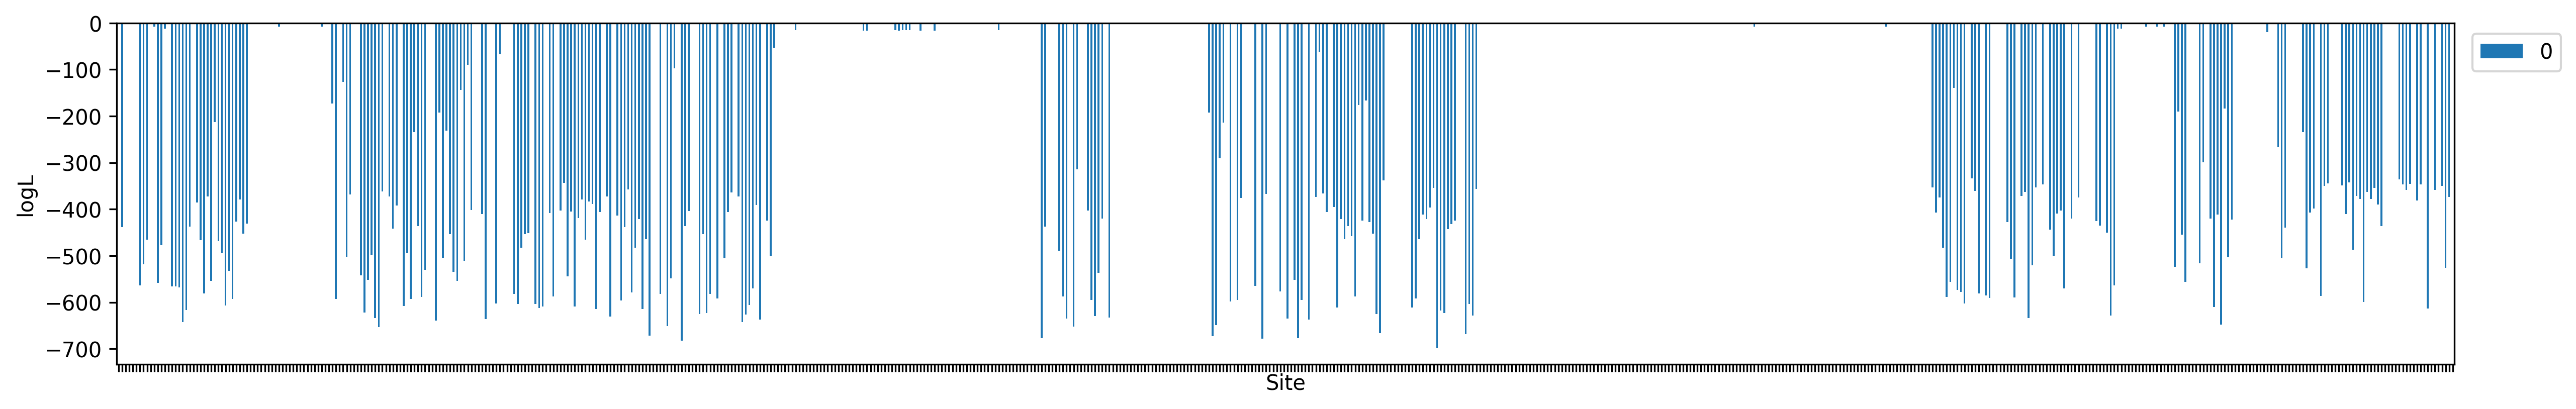

In [13]:
#site_LL_dict

# dict to Dataframe
print("Converting dictionary to dataframe")
df = pd.DataFrame.from_dict(site_LL_dict, orient="index")
print("# Alignment LL =", float(df.sum()))
# Plot a stacked bar chart at each site (kind of a sequence logo plot)
print("Plotting bar chart")
# Set plot config
plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 10})

# Default
df.plot.bar(stacked=True)

# Normalized
#print("Normalizing counts to frequencies")
#df.div(df.sum(axis=1), axis=0).plot.bar() # Normalized

# Set aesthetics for the plot
plt.xlabel("Site")
#plt.xticks([])
plt.tick_params(axis='x', labelbottom=False)
plt.ylabel("logL")
plt.title('')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.show()


# **GC Content**

GC Content (for the entire alignment) is 62.557859681526885%


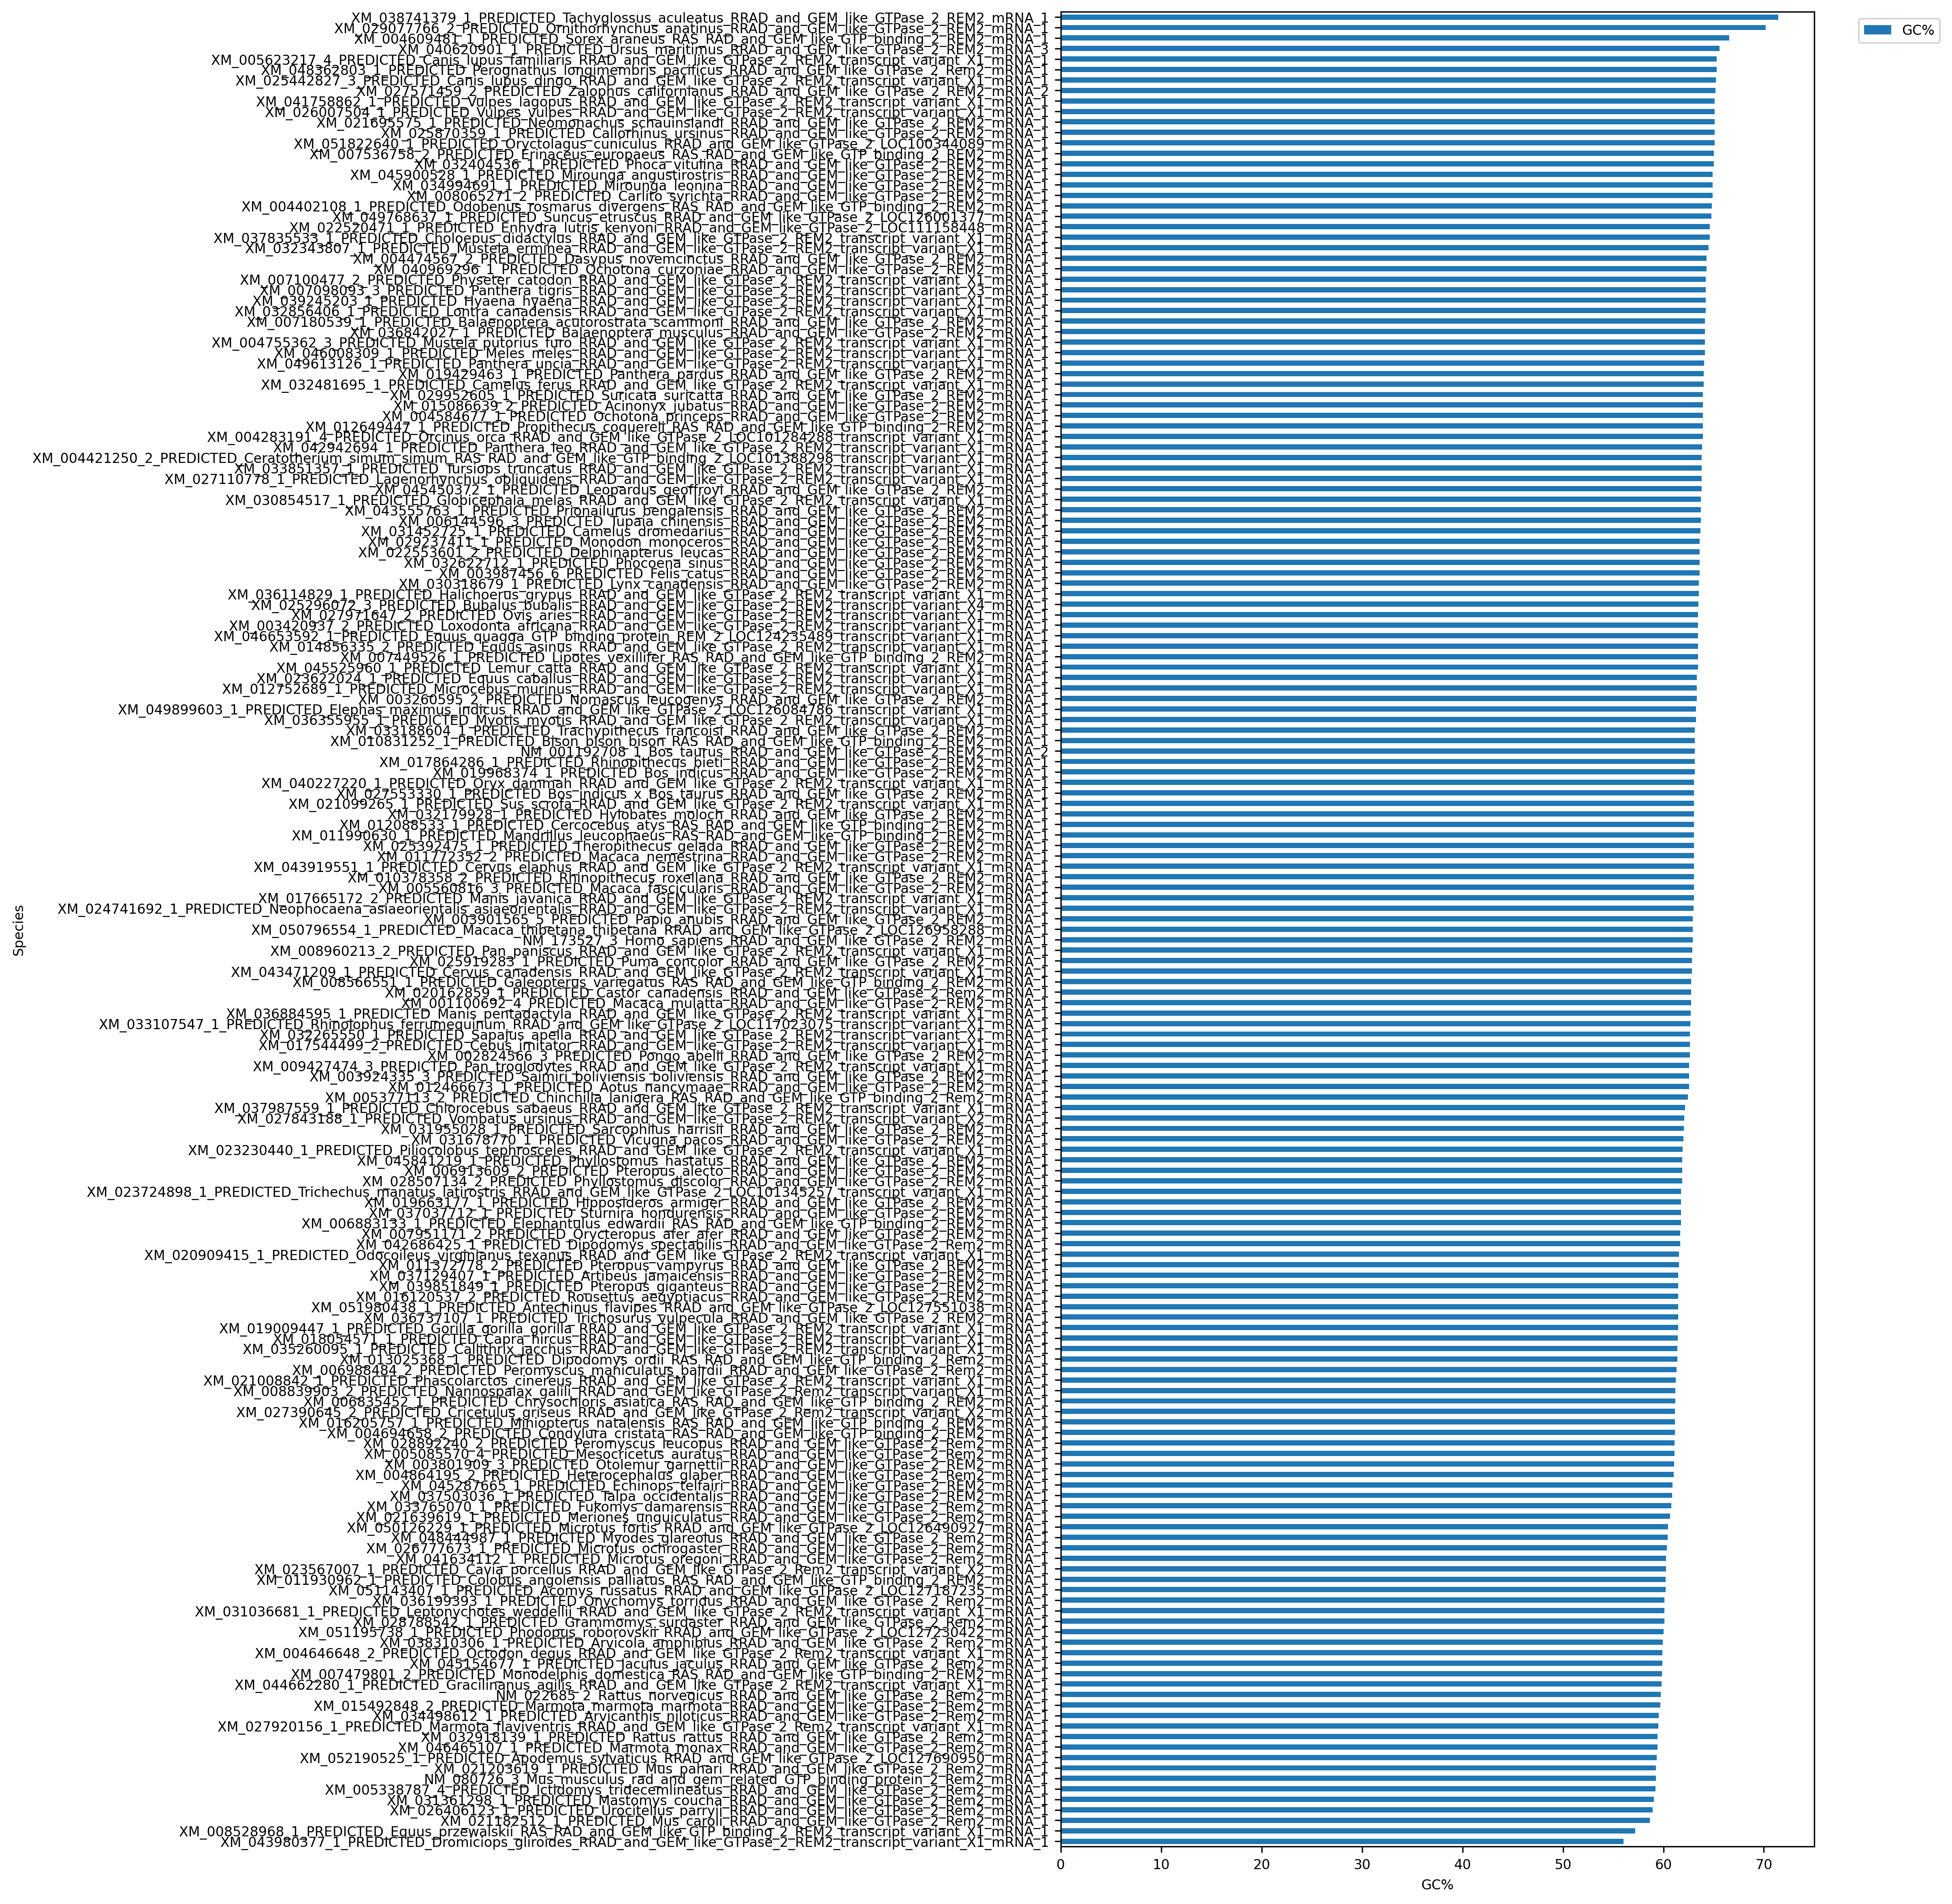

In [14]:
# GC Content
# Count(G + C)/Count(A + T + G + C) * 100%
NT_Dict = {"G": 0, "C":0, "T":0, "A":0}
for key in TEST.FASTA_DICT.keys():
  seq = "".join(TEST.get_full_sequence(key))
  for nt in str(seq):
    if nt.upper() in NT_Dict.keys():
      NT_Dict[nt.upper()] += 1
    #end if
  #end for
#end for

# Calculate GC Content
GC_Content = (NT_Dict["G"] + NT_Dict["C"]) / (NT_Dict["G"] + NT_Dict["C"] + NT_Dict["T"] + NT_Dict["A"]) * 100
print("GC Content (for the entire alignment) is", str(GC_Content) + "%")

# Can plot GC content distribution for each taxa.
GC_Content_dict = {}
for key in TEST.FASTA_DICT.keys():
  seq = "".join(TEST.get_full_sequence(key))
  NT_Dict = {"G": 0, "C":0, "T":0, "A":0}
  for nt in str(seq):
    if nt.upper() in NT_Dict.keys():
      NT_Dict[nt.upper()] += 1
    #end if
  #end for
  GC_Content = (NT_Dict["G"] + NT_Dict["C"]) / (NT_Dict["G"] + NT_Dict["C"] + NT_Dict["T"] + NT_Dict["A"]) * 100
  GC_Content_dict[key] = GC_Content
#end for

df = pd.DataFrame.from_dict(GC_Content_dict, orient="index", columns=["GC%"])
df.sort_values(by=['GC%'], inplace=True)
#df.Index.rename("Taxa", inplace=True)
#print(df)

#plt.rcParams["figure.figsize"] = (3, 2)
#plt.rcParams["figure.dpi"] = 300
#plt.rcParams.update({'font.size': 8})

#df.plot.barh()
#df.plot(linewidth=1.5)

# Set plot config
plt.rcParams["figure.figsize"] = (8,20)
plt.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 8})


df.plot.barh(linewidth=1, y="GC%")
plt.tick_params(axis='x', labelbottom=True)
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.ylabel("Species")
plt.xlabel("GC%")
plt.show()


# **Amino acid relative frequencies**

In [ ]:
## Loop over each site, convert codons to amino acids
site_AA_dict = {}
print("Generating AA counts")

for key in range(1, TEST.num_sites + 1 ):
  site = TEST.get_site_sequence(key)
  site_AA_dict[key] = {}


  for item in site:
    if "-" in item and item != "---": 
       #error reporting
       continue
    AA = Seq(item).translate()
    if str(AA) == "-": continue # skip gaps
    if str(AA) == "X": continue # skip ambious calls
    AA = search(d, str(AA))
    try:
      site_AA_dict[key][AA] += 1
    except:
      site_AA_dict[key][AA] = 1
  #end for
#end for

# dict to Dataframe
print("Converting dictionary to dataframe")
df = pd.DataFrame.from_dict(site_AA_dict, orient="index")

# Set plot config
plt.rcParams["figure.figsize"] = (24,5)
plt.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 6})

# Default
#df.plot.bar(stacked=True)
df = df.sort_index(ascending=True)

# Normalized
print("Normalizing counts to frequencies")
# Plot a stacked bar chart at each site (kind of a sequence logo plot)

print("Plotting stacked bar chart")
df.div(df.sum(axis=1), axis=0).plot.bar(stacked=True) # Normalized


# Set aesthetics for the plot
plt.xlabel("Site")
#plt.xticks([])
plt.tick_params(axis='x', labelbottom=True)
plt.ylabel("AA Frequency")
plt.title('')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.show()


Generating AA counts
Converting dictionary to dataframe
Normalizing counts to frequencies
Plotting stacked bar chart


In [ ]:
df

In [ ]:
site_AA_dict

In [ ]:
df.index.name = '#'

df = df.sort_values(by=['#'])

x = df.sum(axis=1)

x.plot()
# This is the total number of amino acids per site, just the counts 
# Proxy for gappiness

In [ ]:
#https://med.libretexts.org/Courses/Metropolitan_State_University_of_Denver/Introduction_to_Nutrition_(Diker)/06%3A_Proteins/6.02%3A_Defining_Protein#:~:text=Essential%20and%20Nonessential%20Amino%20Acids,-There%20are%20twenty&text=Eleven%20of%20the%20amino%20acids,all%20or%20in%20sufficient%20amounts.
"""
Essential	Nonessential
Histidine	Alanine
Isoleucine	Arginine*
Leucine	Asparagine
Lysine	Aspartic acid
Methionine	Cysteine*
Phenylalanine	Glutamic acid
Threonine	Glutamine*
Tryptophan	Glycine*
Valine	Proline*
Serine
Tyrosine*
"""

import itertools
Essential = ("Histidine", "Isoleucine",  "Leucine", "Lysine", "Methionine", "Phenylalanine", "Threonine", "Tryptophan", "Valine", "Serine", "Tyrosine")
Nonessential = ("Alanine", "Arginine",  "Asparagine", "Aspartic_acid", "Cysteine", "Glutamic_acid", "Glutamine", "Glycine", "Proline")

Essential = map(lambda x:x.upper(), Essential)
Nonessential = map(lambda x:x.upper(), Nonessential)

#list(Essential)
#list(df.columns.values)

_essential = []
_nonessential = []
df.columns = [c.replace(' ', '_') for c in df.columns]
for row in df.itertuples():
    #print(row.Index)
    #print(row)

    # Essential
    count_essential = 0
    #print(type(row.HISTIDINE))HISTIDINE
    if row.HISTIDINE > 0: count_essential += row.HISTIDINE
    if row.ISOLEUCINE > 0: count_essential += row.ISOLEUCINE
    if row.LEUCINE > 0: count_essential += row.LEUCINE
    if row.LYSINE > 0: count_essential +=  row.LYSINE
    if row.PHENYLALANINE > 0: count_essential += row.PHENYLALANINE
    if row.THREONINE > 0: count_essential += row.THREONINE
    if row.TRYPTOPHAN > 0: count_essential += row.TRYPTOPHAN
    if row.VALINE > 0: count_essential +=  row.VALINE
    if row.SERINE > 0: count_essential += row.SERINE
    if row.TYROSINE > 0: count_essential += row.TYROSINE
    if row.METHIONINE > 0: count_essential += row.METHIONINE # 11 AAs total for essential
    _essential.append(count_essential)

    # Nonessential
    count_nonessential = 0
    if row.ALANINE > 0: count_nonessential += row.ALANINE
    if row.ARGININE > 0: count_nonessential += row.ARGININE
    if row.ASPARAGINE > 0: count_nonessential += row.ASPARAGINE
    if row.ASPARTIC_ACID > 0: count_nonessential += row.ASPARTIC_ACID
    if row.CYSTEINE > 0: count_nonessential += row.CYSTEINE
    if row.GLUTAMIC_ACID > 0: count_nonessential += row.GLUTAMIC_ACID
    if row.GLUTAMINE > 0: count_nonessential += row.GLUTAMINE
    if row.GLYCINE > 0: count_nonessential += row.GLYCINE
    if row.PROLINE > 0: count_nonessential += row.PROLINE # 9 AAs total
    _nonessential.append(count_nonessential)
#end for

df["Essential"] = _essential
df["Nonessential"] = _nonessential

#for row in df:
#  print(row)
  #for col in Essential:
  #  print(row[col])
"""
# loop over the rows
for row in df.itertuples():
    #print (row["Name"], row["Age"])
    print(row[0], row)
    continue
    # Essential
    for AA in Essential:
      print(index, AA, row[AA])
    #end for
    #print()
    for AA in Nonessential:
      print(index, AA, row[AA])
    #end for
#end for
"""
  # loop over the columns
  #for col in df.iteritems:
  #   value = df[col][row]
  #   print(value)
     # if the value is NaN, goto next column
     # otherwise, is the Column header in the essential or nonessential bucket
     # if so, add it to the count for that bucket.
  # end column for
  # _essential.append(count_essential)
  # _nonessential.append(count_nonessential)
#df["Essential"] = []
#df["Nonessential"] = []


In [ ]:
df

In [ ]:
# Set plot config
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 10})

df["Essential"].plot()
df["Nonessential"].plot()
#x.plot() # Total number of Amino acids at that site
plt.legend()

In [ ]:
# This code 'zooms in' on a particular region of the alignment.
start = 200
end = 580
#x = df.sum(axis=1)
#x.plot()
dfRange = df.iloc[start:end]
x_dfRange = dfRange.sum(axis=1)
x_dfRange.plot()
dfRange["Essential"].plot()
dfRange["Nonessential"].plot()

# **Ungapped NT content (a form of information content)**
Since these analyses assume a matrix (alignment). We want to know how many 'pure' NTs are in each sequence and how it varies across the alignment

In [ ]:
## Code
sequence_lengths = {}

for key in TEST.FASTA_DICT.keys():
  #sequence_lengths[key] = len(TEST.get_full_sequence(key).replace("-", ""))
  seq = "".join(TEST.get_full_sequence(key))
  seq = seq.replace("-", "")
  sequence_lengths[key] = len(seq)
# end for

# Plot
plt.scatter(y=sequence_lengths.keys(),  x=sequence_lengths.values(), color='blue', marker="|")
plt.rcParams["figure.figsize"] = (5,3)
#plt.xticks([])
plt.xlabel("Num. Of Nucleotides")
plt.show()

# **Bootstrapping an alignment**

In [ ]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

TEST = AlignmentProfiler(input_file, CodonTable)
x = TEST.bootstrap_columns()
TAXA = TEST.FASTA_DICT.keys()

new_seq_dict = {}
for n, species in enumerate(TAXA):
  for site in x:
    try:
      new_seq_dict[species] += TEST.FASTA_DICT[species]["Site"+str(site)]
    except:
      new_seq_dict[species] = TEST.FASTA_DICT[species]["Site"+str(site)]
  #end for
#end for

records = []
for n, species in enumerate(TAXA):
  #record = SeqRecord(Seq("ATG"), id=species)
  record = SeqRecord(Seq(new_seq_dict[species]), id=species, name="", description="")
  records.append(record)
#end for

with open("example.fasta", "w") as output_handle:
    SeqIO.write(records, output_handle, "fasta")
#end with

#Download?
from google.colab import files
files.download('example.fasta') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Testing for Ambiguous Characters**

In [ ]:
print("# Searching for ambiguous characters")
print("Taxa, [Site, Codon]")
ambig_chars = TEST.ambiguous_characters() #actually returns the taxa names.
#print(ambig_chars)
for item in ambig_chars:
  print(item, ambig_chars[item])

# Searching for ambiguous characters
Taxa, [Site, Codon]


## **Gap character analysis**

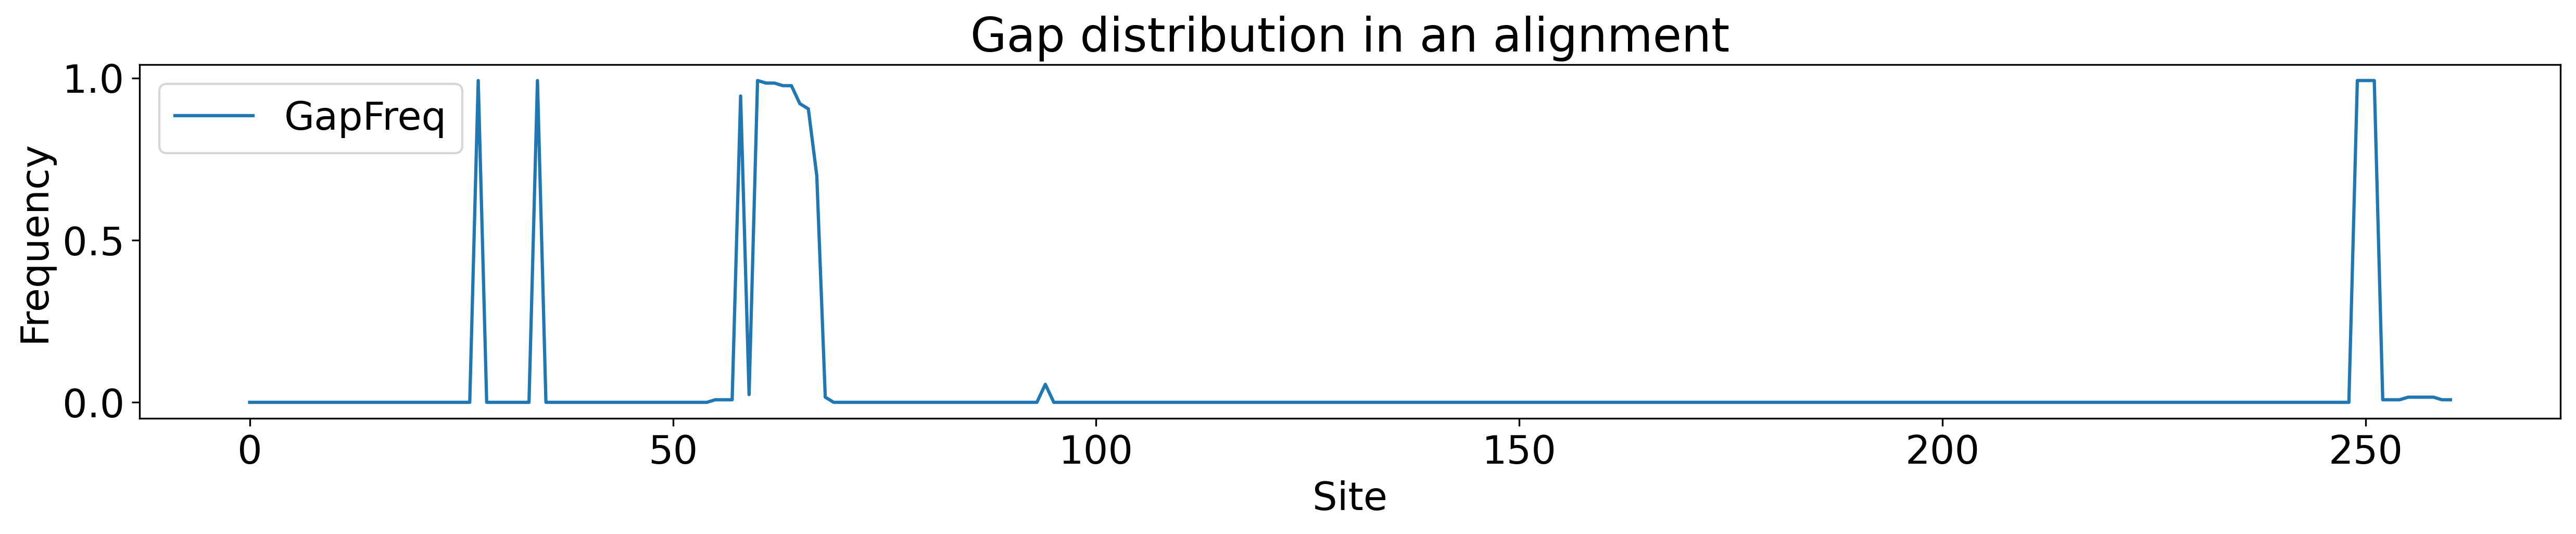

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(TEST.gaps_distribution(), label="GapFreq")
plt.xlabel("Site")
plt.ylabel("Frequency")
plt.title('Gap distribution in an alignment')
plt.legend()
plt.show()

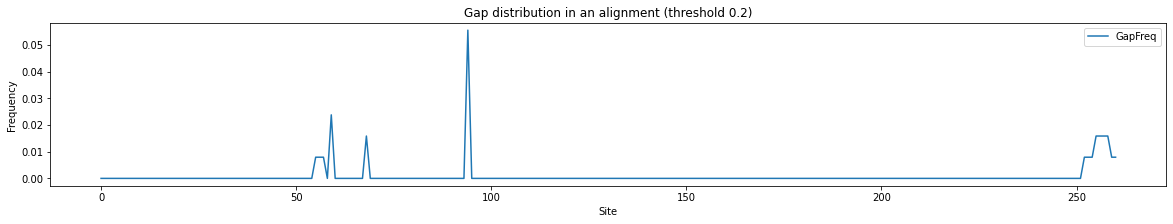

59 0.023809523809523808
68 0.015873015873015872
94 0.05555555555555555
255 0.015873015873015872
256 0.015873015873015872
257 0.015873015873015872
258 0.015873015873015872


In [ ]:
# This code thresholds the above by a gap range

import numpy as np
gaps = np.array(TEST.gaps_distribution())
#gaps = TEST.gaps_distribution()
#filtered_numbers = [number for number in gaps if number < 0.2 else: number = 0]
filtered_numbers =  np.where(gaps>0.2, 0, gaps) 
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(filtered_numbers, label="GapFreq")
plt.xlabel("Site")
plt.ylabel("Frequency")
plt.title('Gap distribution in an alignment (threshold 0.2)')
plt.legend()
plt.show()

for n, item in enumerate(filtered_numbers):
  if item > 0.01:
    print(n, item)


# **Codon Diversity**

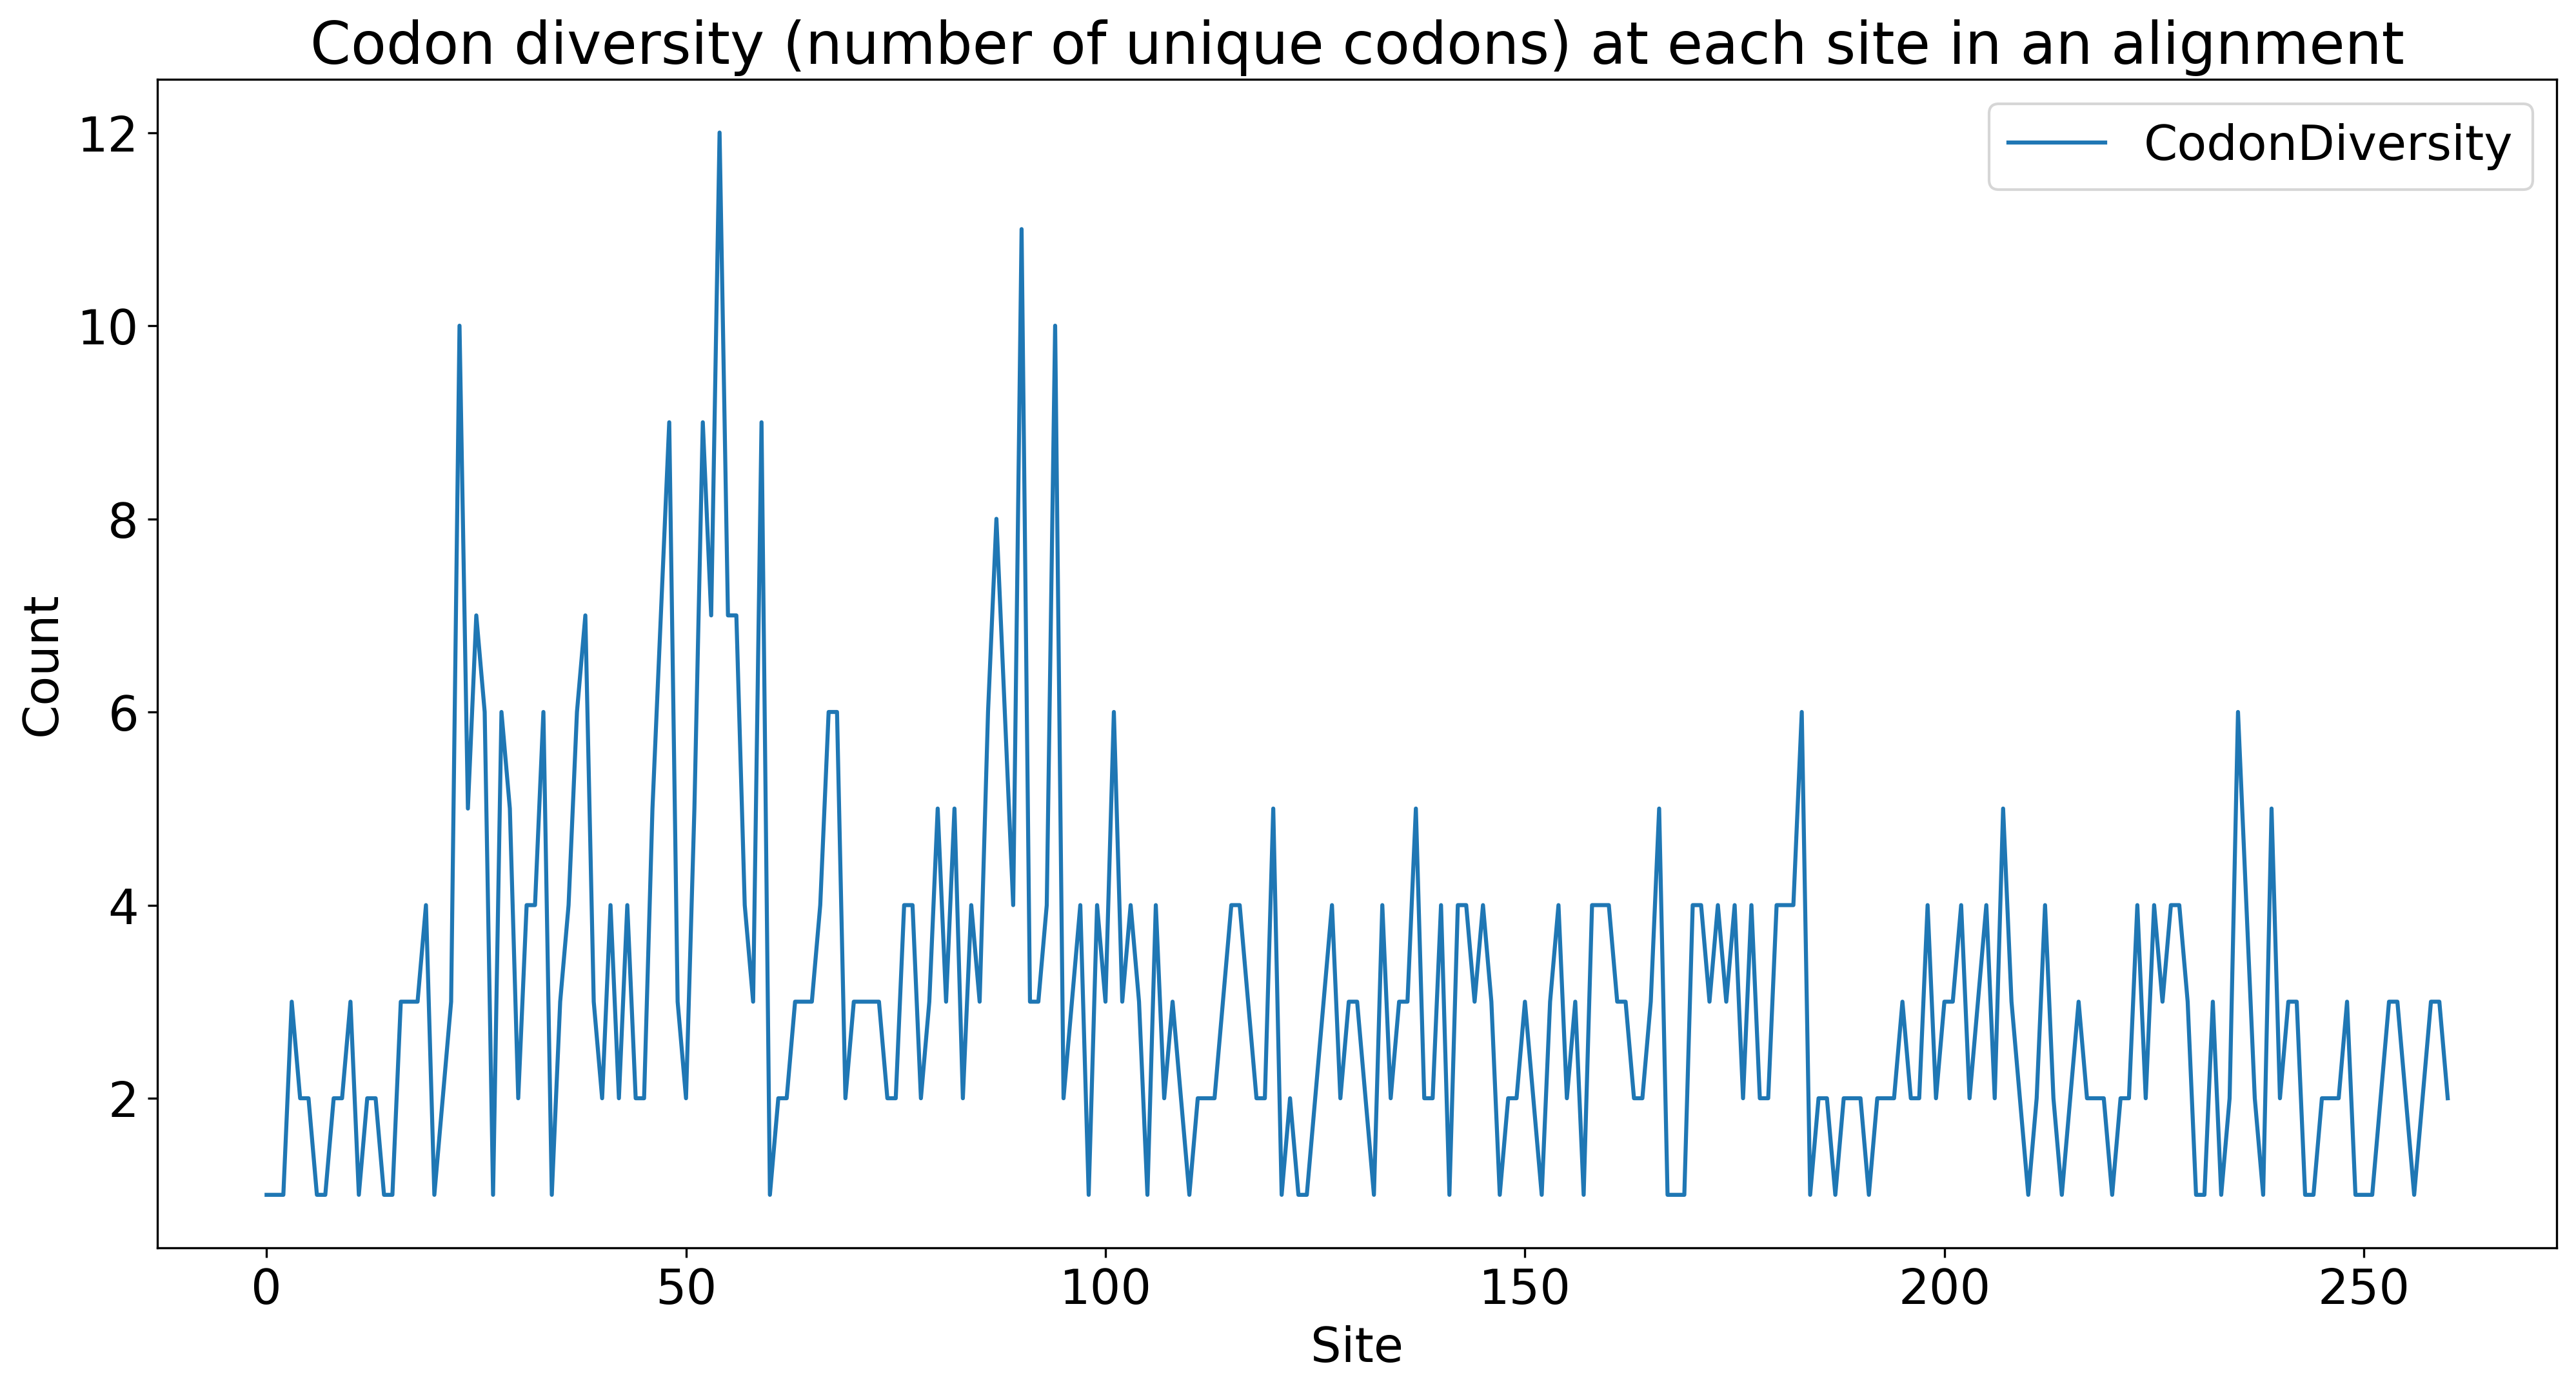

In [ ]:
# Set plot config
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 18})

plt.plot(TEST.codon_diversity(), label="CodonDiversity")
plt.xlabel("Site")
plt.ylabel("Count")
plt.title('Codon diversity (number of unique codons) at each site in an alignment')
plt.legend()
plt.show()

# Does not consider synyonymous codons, just 'unique' codons at sites.
# ^ this needs to be accounted for in the future.

# **Protein Diversity**

In [ ]:
plt.plot(TEST.protein_diversity(), label="ProteinDiversity")
plt.xlabel("Site")
plt.ylabel("Count")
plt.title('Protein diversity (number of unique amino acids) at each site in an alignment')
plt.legend()
plt.show()

# Does not consider synyonymous codons, just 'unique' codons at sites.
# ^ this needs to be accounted for in the future.

TranslationError: ignored

In [ ]:
#https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
#fig = plt.figure(figsize =(3, 2))
plt.boxplot(TEST.protein_diversity(), patch_artist = True)
plt.xlabel("Site")
plt.ylabel("Count")
plt.title('Protein diversity (number of unique amino acids) at each site in an alignment')
plt.legend()
plt.show()

## **Hamming Distance plot**

In [ ]:
print("# Calculating pairwise hamming distances")
HD_dict

In [ ]:
# Process Data
print("# Calculating pairwise hamming distances")
HD_dict = TEST.pairwise_distances()

# Convert to dataframe (makes it easier to plot)
df = pd.DataFrame.from_dict(HD_dict, orient='index')
# Can save the df here.

# Plot
print("# Plotting")
figure(num=None, figsize=(18, 16), dpi=300, facecolor='w', edgecolor='k')
df = pd.DataFrame.from_dict(HD_dict, orient='index')
plt.pcolormesh(df)
plt.yticks(np.arange(0.005, len(df.index), 1), df.index)
#plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xlabel("Species Number")
plt.colorbar()
plt.title("Hamming Distance on Alignment")
plt.show()

# Histogram, mean distribution of distances
#df.describe()

#df2 = df.describe().transpose()
#df2 = df2.loc[df2['mean']]
#df2['mean'].hist()
#df2['mean'].plot.bar()

# **Save Hamming Distances**

In [ ]:
df = pd.DataFrame.from_dict(HD_dict)
df.to_csv("HammingDistances.csv")

In [ ]:
!head HammingDistances.csv

# **Jukes Cantor Distances**

In [ ]:
JC_dict = TEST.JukesCantorDistance()
df = pd.DataFrame.from_dict(JC_dict)
df

NM_001709_5_Homo_sapiens_brain_derived_neurotrophi  ...  XM_004418542_2_PREDICTED_Ceratotherium_simum_simum
NM_001270630_1_Rattus_norvegicus_brain_derived_neu                                           0.087978   ...                                                NaN 
NM_001048142_1_Mus_musculus_brain_derived_neurotro                                           0.087978   ...                                                NaN 
XM_015114598_2_PREDICTED_Macaca_mulatta_brain_deri                                           0.007702   ...                                                NaN 
XM_005654684_3_PREDICTED_Sus_scrofa_brain_derived_                                           0.092299   ...                                                NaN 
NM_001009828_1_Felis_catus_brain_derived_neurotrop                                           0.054280   ...                                                NaN 
...                                                                                               ...   ...                                                ... 
XM_012523604_2_PREDICTED_Dasypus_novemcinctus_brai                                           0.052909   ...                                                NaN 
XM_029059317_2_PREDICTED_Ornithorhynchus_anatinus_                                           0.171440   ...                                                NaN 
XM_038764545_1_PREDICTED_Tachyglossus_aculeatus_br                                           0.160287   ...                                                NaN 
XM_004418542_2_PREDICTED_Ceratotherium_simum_simum                                           0.055655   ...                                                NaN 
XM_004369733_1_PREDICTED_Trichechus_manatus_latiro                                           0.032628   ...                                           0.057031 

[125 rows x 125 columns]

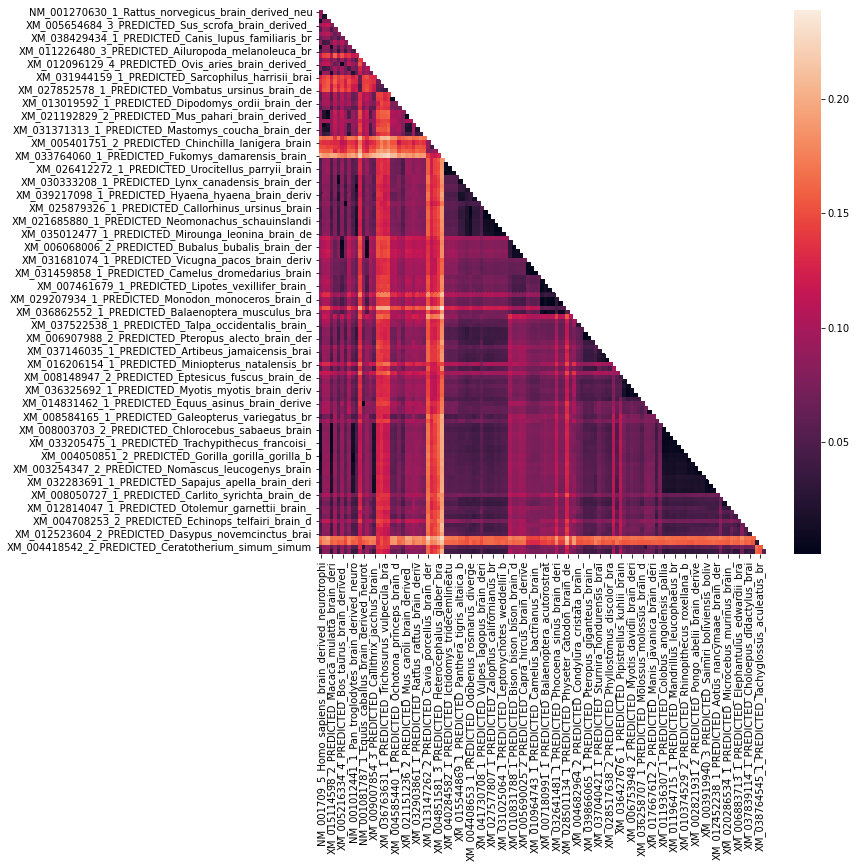

In [21]:
# Plot
#import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df, annot=False, linewidths=0, ax=ax)

#sns.heatmap(df, annot=False)

# **Relative Synonymous Codon Usage**

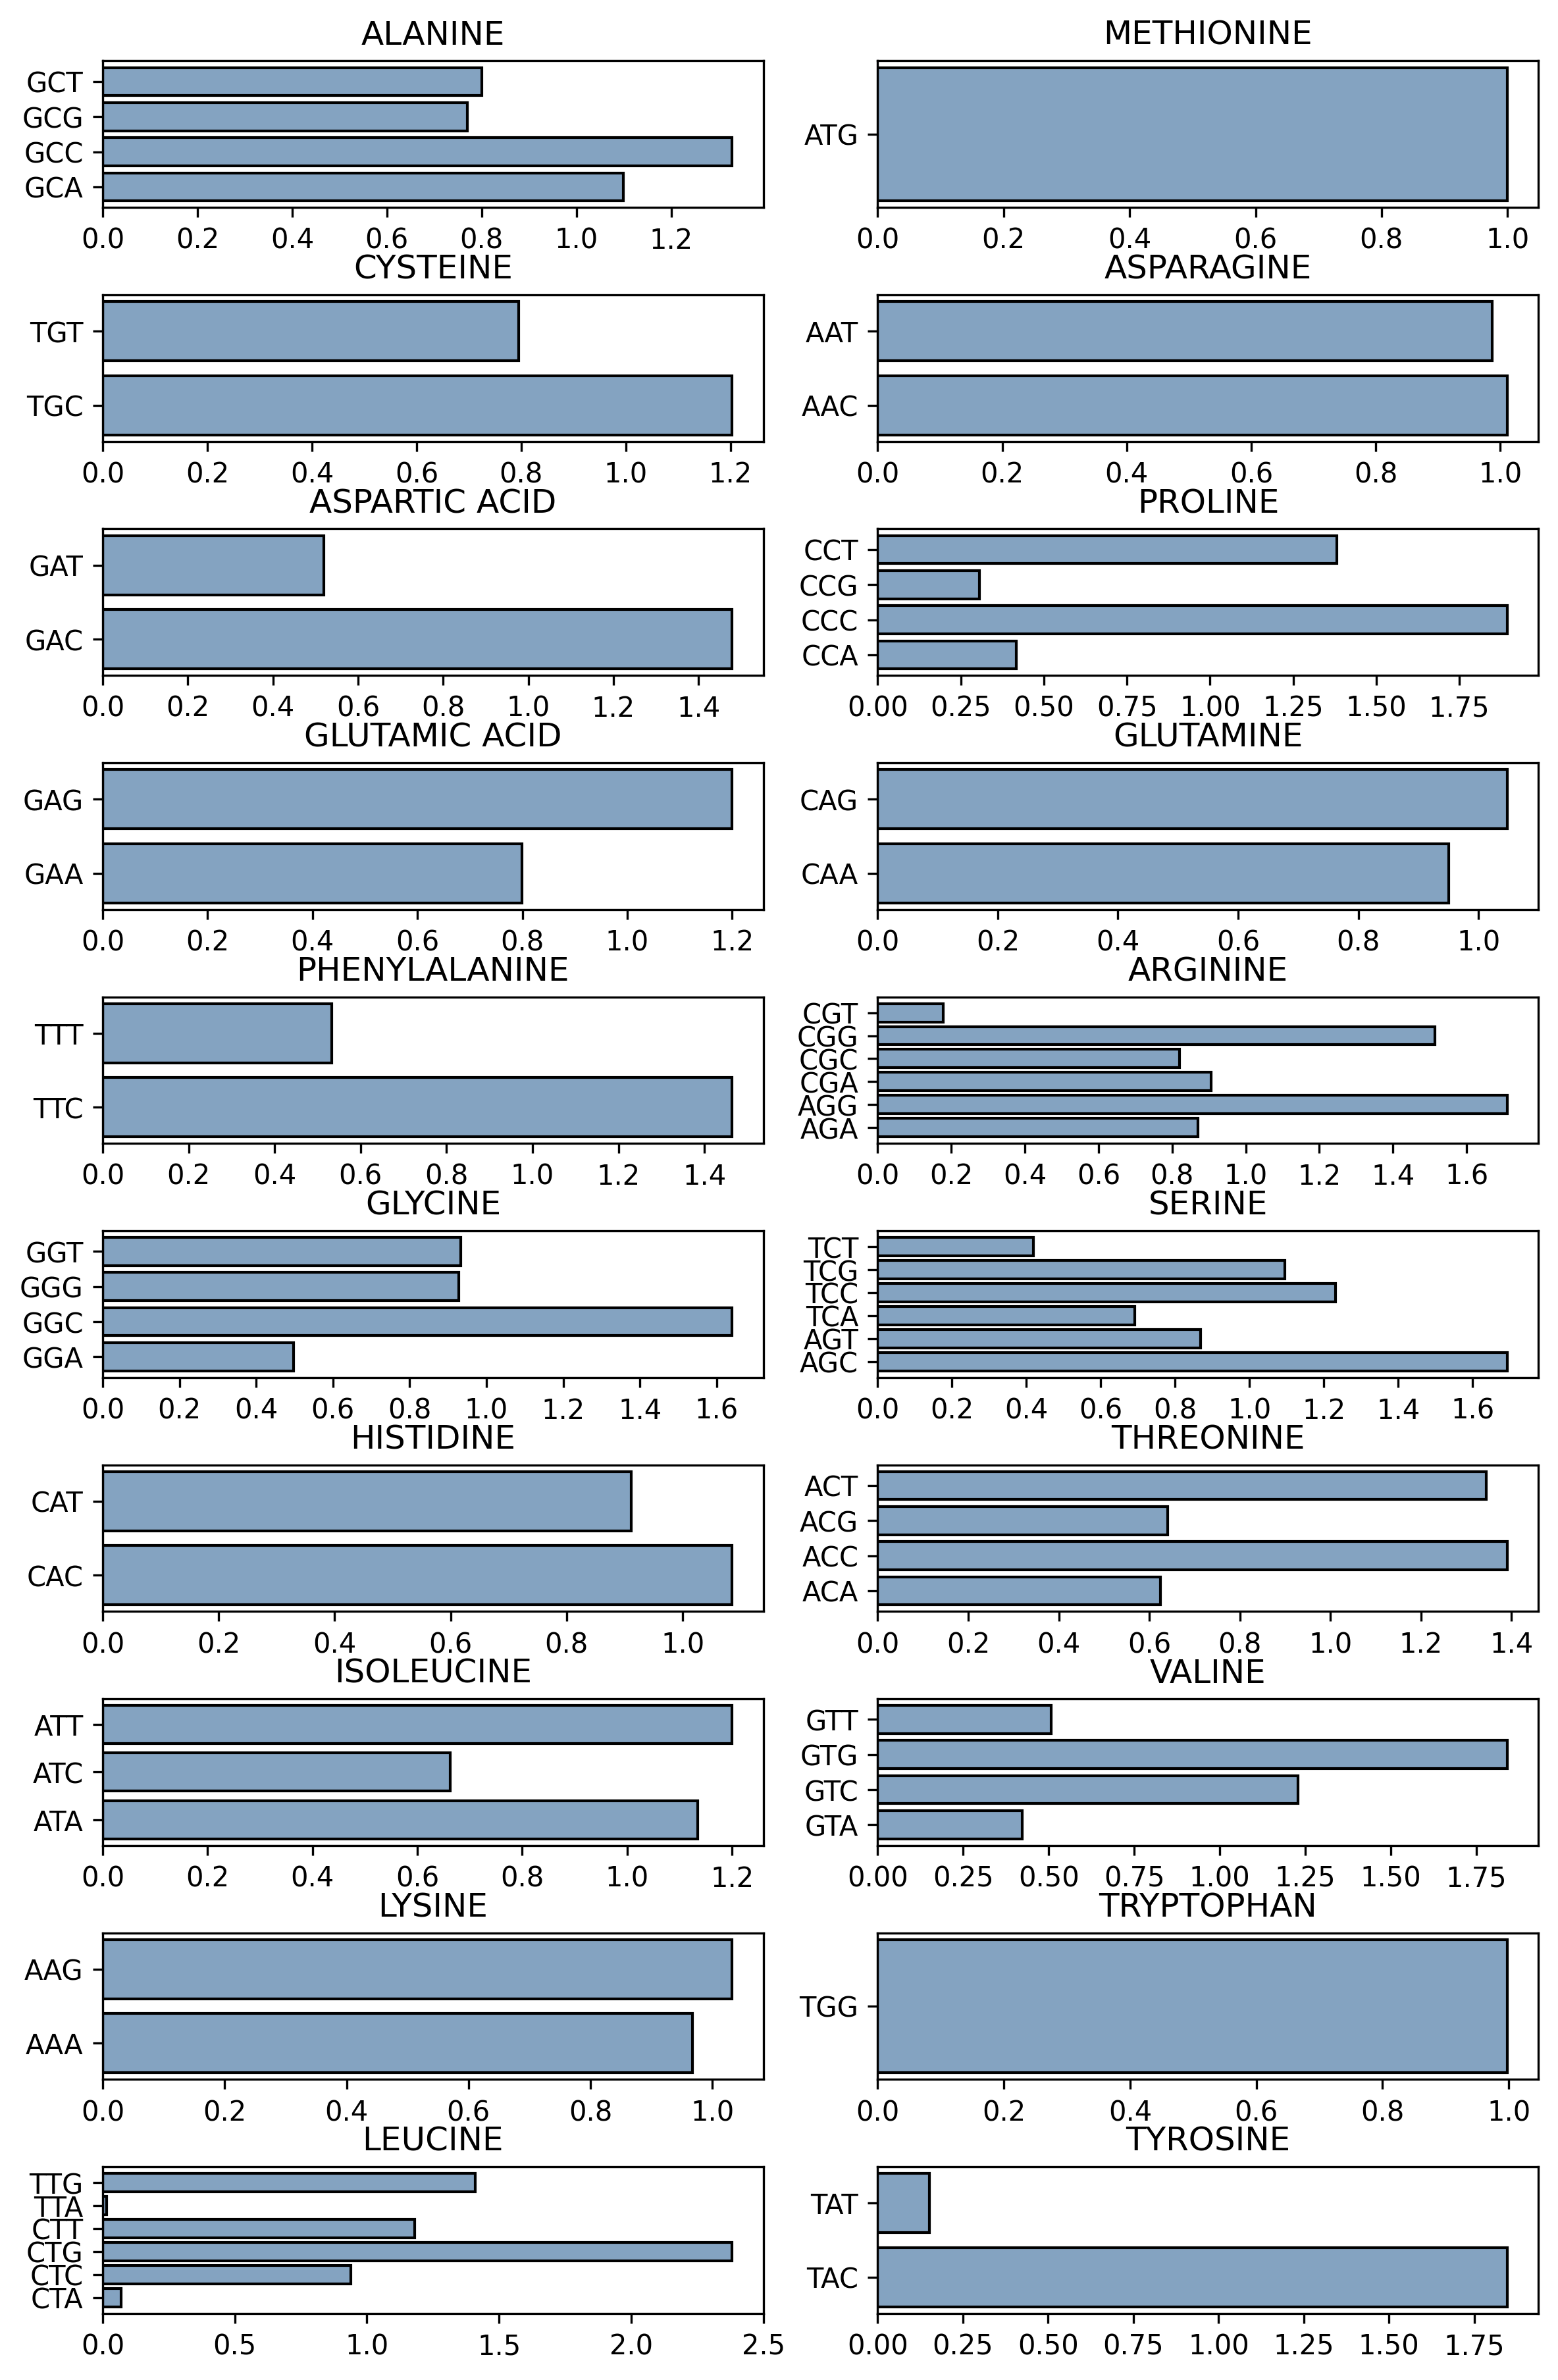

In [ ]:

# Gather data
data = TEST.RSCU()
# Codon Table (Universal for now)
# http://www.cryst.bbk.ac.uk/education/AminoAcid/the_twenty.html
c = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

d = {'CYSTEINE': 'C', 'ASPARTIC ACID': 'D', 'SERINE': 'S', 'GLUTAMINE': 'Q', 'LYSINE': 'K',
     'ISOLEUCINE': 'I', 'PROLINE': 'P', 'THREONINE': 'T', 'PHENYLALANINE': 'F', 'ASPARAGINE': 'N', 
     'GLYCINE': 'G', 'HISTIDINE': 'H', 'LEUCINE': 'L', 'ARGININE': 'R', 'TRYPTOPHAN': 'W', 
     'ALANINE': 'A', 'VALINE':'V', 'GLUTAMIC ACID': 'E', 'TYROSINE': 'Y', 'METHIONINE': 'M'}
     
#print(plt.style.available)
fig, axs = plt.subplots(10, 2)
fig.set_size_inches(8, 12, forward=True)
fig.tight_layout()

#fig, axs = plt.subplots(10, 2)
#fig.set_size_inches(9, 15, forward=True)
#fig.tight_layout()

#fig.suptitle('Horizontally stacked subplots')
#ax1.plot(x, y)
#ax2.plot(x, -y)
row, col = 0, 0
for AA in data.keys(): # Subplots
  if AA == "X": continue # Skip ambiguous AA, we want the core 20
  
  axs[row, col].barh(list(data[AA].keys()), data[AA].values(), color=(0.2, 0.4, 0.6, 0.6), edgecolor='black')
  axs[row, col].set_title(search(d, AA))
  row += 1
  if row == 10: 
    col += 1
    row = 0
  #plt.barh(list(data[AA].keys()), data[AA].values(), color='g')
  #plt.barh(list(data[AA].keys()), data[AA].values())
  #plt.style.use('tableau-colorblind10')
  #plt.xlabel("RSCU")
  #AA_name = search(d, AA)
  #if AA_name == None: AA_name = "X"
  #plt.ylabel(AA_name)

# Set plot config
#plt.rcParams["figure.figsize"] = (24, 8)
#plt.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 8})

plt.savefig(input_file + "_CodonFrequency_ALL"+".png", dpi=300)
plt.show()

# **Ka/Ks calculation**

100%|██████████| 7875/7875 [01:44<00:00, 75.09it/s]


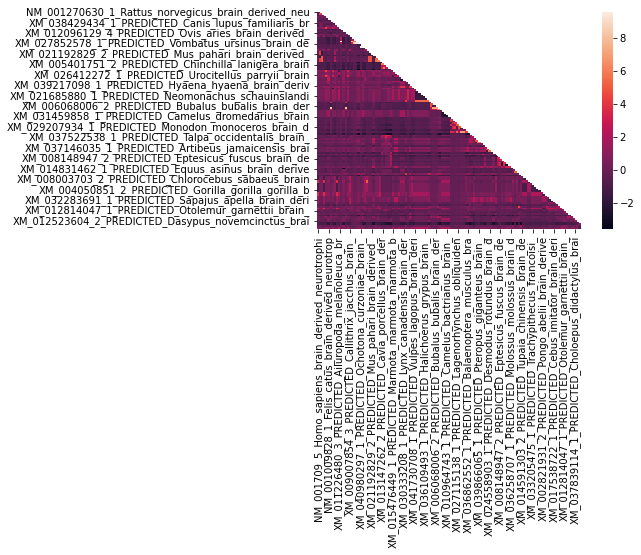

In [ ]:
results = TEST.pairwise_KaKs()

df = pd.DataFrame.from_dict(results)

#df
# Save df in case of error
df.to_csv("KaKs.csv")

normalized_df=(df-df.mean())/df.std()
#normalized_df=(df-df.min())/(df.max()-df.min())

# Plot
sns.heatmap(normalized_df, annot=False)